In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
block_size = 3
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
def build_dataset(words):
    block_size = 5
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [34]:
n_emb = 10
n_hidden = 200
block_size = 5
vocab_size = len(itos.keys())

C = torch.randn((vocab_size, n_emb))
W1 = torch.randn((n_emb*block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size)) * 0.0001
b2 = torch.randn(vocab_size) * 0


parameters = [C, W1, W2, b1, b2]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(200000+1):
    # making batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Y[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f"{i}/{max_steps} Loss: {loss.item()}")
    lossi.append(loss.item())
    break 

0/200000 Loss: 3.296082019805908


In [ ]:
h

torch.Size([32, 200])

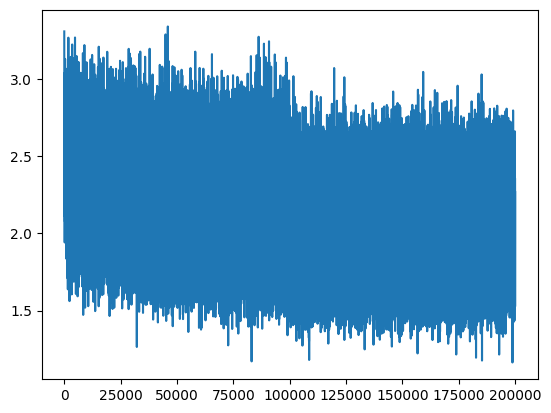

In [31]:
plt.plot(lossi)

In [32]:
@torch.no_grad
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]

    emb = C[x]
    out = emb.view(emb.shape[0], -1) @ W1 + b1
    h = torch.tanh(out)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.030921220779419
val 2.121659278869629


In [ ]:
block_size = 5
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True)
        context = context[1:] + [ix]
        out.append(itos[ix.item()])
        if ix == 0:
            print(''.join(out[:-1]))
            out = []
            break 

# Loss Evolution:
- 